# DS-NYC-45 | Final Project 4: Modeling Performance

#### 1) Load Relevant Libraries and Data

In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn as skl
from sklearn import ensemble, metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor,ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ShuffleSplit, cross_val_score

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

%matplotlib inline
plt.style.use('ggplot')

In [13]:
users = pd.read_csv(os.path.join('project_dataset', 'user_data.csv'), index_col='user_id')
res = pd.read_csv(os.path.join('project_dataset', 'reservations_data.csv'), index_col='user_id')

#### 2) Combine & Clean Data

In [14]:
df = pd.concat([users, res], axis=1, join_axes=[users.index])

In [15]:
df = df.fillna(0)
df.head()

,is_converted,lead_created_month,lead_created_day_of_week,is_paidsocial_lead,is_organic_lead,is_seo_studios,is_inviteafriend,is_email,is_referral,is_paidsocial,is_organic,user_acquisition_month,user_acquisition_day_of_week,promo_days,lead_to_promo_days,is_three_studio_visits,is_two_studio_visits,is_four_studio_visits,is_onboarded,user_country,user_msa_id,avg_class_rating,avg_days_from_booking_to_class,avg_peak_classes,reservations_attended_barre_count,reservations_attended_boxing_count,reservations_attended_cycling_count,reservations_attended_dance_count,reservations_attended_gym_count,reservations_attended_martial_arts_count,reservations_attended_pilates_count,reservations_attended_rowing_count,reservations_attended_strength_training_count,reservations_attended_yoga_count,reservations_attended_t1_count,reservations_attended_t2_count,reservations_attended_t3_count,reservations_attended_count,reservations_missed_count,reservations_late_cancelled_count,cost_of_all_reservations_in_usd_no_tax
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12,0,5,4,0,1,0,0,0,0,0,1,9.0,3.0,0.0,0,1,0,0,1,1.0,1.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0,5,5,0,1,0,0,0,0,0,1,9.0,3.0,0.0,0,1,0,0,1,1.0,1.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,1,6,1,0,1,0,0,0,0,0,1,9.0,1.0,0.0,0,0,1,0,1,1.0,1.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,1,7,3,0,1,0,0,0,0,0,1,8.0,4.0,0.0,0,1,0,0,1,1.0,1.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,1,6,1,0,1,0,0,0,0,0,0,8.0,3.0,30.0,429,0,1,0,1,1.0,1.0,5.0,1.25,0.75,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,25.0


In [16]:
df.shape

(592322, 41)

In [17]:
df.dtypes

is_converted                                       int64
lead_created_month                                 int64
lead_created_day_of_week                           int64
is_paidsocial_lead                                 int64
is_organic_lead                                    int64
is_seo_studios                                     int64
is_inviteafriend                                   int64
is_email                                           int64
is_referral                                        int64
is_paidsocial                                      int64
is_organic                                         int64
user_acquisition_month                           float64
user_acquisition_day_of_week                     float64
promo_days                                       float64
lead_to_promo_days                                 int64
is_three_studio_visits                             int64
is_two_studio_visits                               int64
is_four_studio_visits          

#### 3) Split Data into X, Y, test & train

In [18]:
X = df.drop('is_converted', axis=1)
y = df['is_converted'].astype(int)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### 4) Create Calculation for Model Results

In [20]:
def format_model_results(sklearn_model, X_train, X_test, y_train, y_test):
    # Get the model's class name (E.g. LogisticRegression, KNearestNeighbor, etc.) and store it to a string
    model_class_name = sklearn_model.__class__.__name__  
    
    y_test_pred   = sklearn_model.predict(X_test)
    y_train_pred  = sklearn_model.predict(X_train)

    accuracy_score  = metrics.accuracy_score(y_test, y_test_pred)
    precision_score = metrics.precision_score(y_test, y_test_pred, average='binary')
    recall_score    = metrics.recall_score(y_test, y_test_pred, average='binary')
    f1_score        = metrics.f1_score(y_test, y_test_pred, average='binary')
    f1_score_train  = metrics.f1_score(y_train, y_train_pred, average='binary')
    
    return pd.DataFrame({
            "Accuracy": accuracy_score, 
            "Precision": precision_score, 
            "Recall": recall_score, 
            "F1 score": f1_score, 
            "F1 score (train)": f1_score_train
        }, index=[model_class_name])

#### 5) Run Feature Extraction Models
##### Model A: Decision Tree Classifier`

In [21]:
dtc = DecisionTreeClassifier()    
dtc.fit(X, y)

def build_tree_image(dtc):
    dotfile = open("tree.dot", 'w')
    export_graphviz(dtc, out_file = dotfile, feature_names = X.columns)
    dotfile.close()
    os.system("dot -Tpng tree.dot -o tree.png")

dtc = DecisionTreeClassifier(
                max_depth = 5,
                min_samples_leaf = 10)

dtc.fit(X, y)
build_tree_image(dtc)

In [22]:
dtc = DecisionTreeClassifier(
                max_depth = 5,
                min_samples_leaf = 10)

dtc.fit(X, y)
build_tree_image(dtc)

In [26]:
format_model_results(dtc, X_train, X_test, y_train, y_test)

,Accuracy,F1 score,F1 score (train),Precision,Recall
DecisionTreeClassifier,0.752518,0.803725,0.804255,0.829778,0.779258


##### Model B: Random Forest Classifier

In [27]:
rfc = RandomForestClassifier(n_estimators = 30)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [28]:
format_model_results(rfc, X_train, X_test, y_train, y_test)

,Accuracy,F1 score,F1 score (train),Precision,Recall
RandomForestClassifier,0.788993,0.838217,0.995975,0.835799,0.840649


In [32]:
features = X.columns
feature_importances = rfc.feature_importances_

features_rfc = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_rfc.sort_values('Importance Score', inplace=True, ascending=False)

print features_rfc

                                         Features  Importance Score
12                                     promo_days          0.139555
39         cost_of_all_reservations_in_usd_no_tax          0.104098
10                         user_acquisition_month          0.065383
19                                    user_msa_id          0.047933
21                 avg_days_from_booking_to_class          0.047169
36                    reservations_attended_count          0.045012
0                              lead_created_month          0.043398
20                               avg_class_rating          0.042633
22                               avg_peak_classes          0.041930
9                                      is_organic          0.038926
13                             lead_to_promo_days          0.035416
11                   user_acquisition_day_of_week          0.032755
1                        lead_created_day_of_week          0.030601
33                 reservations_attended_t1_coun

In [33]:
scores = cross_val_score(rfc, X, y, scoring='accuracy')
print('CV Accuracy {}, Average Accuracy {}'.format(scores, scores.mean()))

for n_trees in range(1, 211, 30):
    model = RandomForestClassifier(n_estimators = n_trees)
    scores = cross_val_score(model, X, y, scoring='accuracy')
    print('n trees: {}, CV accuracy {}, Average accuracy {}'.format(n_trees, scores, scores.mean()))

CV Accuracy [ 0.6563733   0.47361997  0.3969763 ], Average Accuracy 0.508989853469
n trees: 1, CV accuracy [ 0.65974139  0.49753597  0.4140549 ], Average accuracy 0.523777422209
n trees: 31, CV accuracy [ 0.65623655  0.47836569  0.42431118], Average accuracy 0.51963780625
n trees: 61, CV accuracy [ 0.65600863  0.47687157  0.41374088], Average accuracy 0.515540361831
n trees: 91, CV accuracy [ 0.65584149  0.47619795  0.41577188], Average accuracy 0.515937108253
n trees: 121, CV accuracy [ 0.65577058  0.47603588  0.41989465], Average accuracy 0.517233705081
n trees: 151, CV accuracy [ 0.65580097  0.4761473   0.41867909], Average accuracy 0.516875790201
n trees: 181, CV accuracy [ 0.65579084  0.47579783  0.41861325], Average accuracy 0.516733975573


##### Model C: Extra Trees Classifier

In [34]:
etc = ExtraTreesClassifier()
etc.fit(X, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

                                               importance
feature                                                  
promo_days                                          0.083
is_organic                                          0.077
user_acquisition_month                              0.063
avg_class_rating                                    0.052
user_msa_id                                         0.047
lead_created_month                                  0.043
avg_peak_classes                                    0.042
is_onboarded                                        0.038
cost_of_all_reservations_in_usd_no_tax              0.037
user_acquisition_day_of_week                        0.035
is_three_studio_visits                              0.035
avg_days_from_booking_to_class                      0.033
lead_created_day_of_week                            0.032
reservations_attended_count                         0.029
lead_to_promo_days                                  0.029
reservations_a

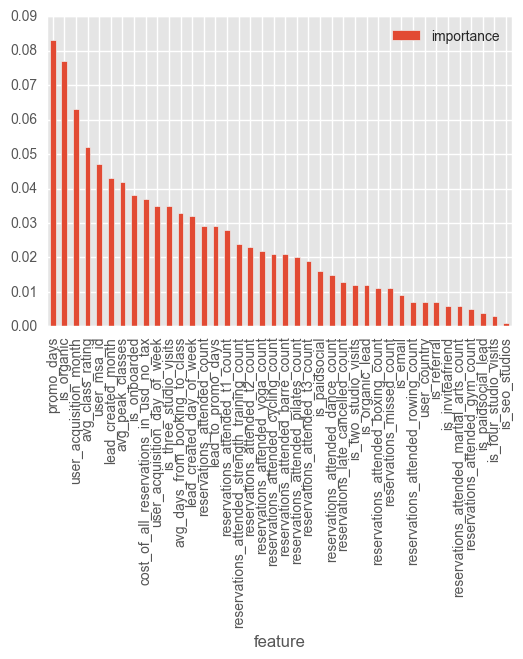

In [35]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(etc.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
print importances
importances.plot.bar()

In [36]:
format_model_results(etc, X_train, X_test, y_train, y_test)

,Accuracy,F1 score,F1 score (train),Precision,Recall
ExtraTreesClassifier,0.994606,0.995847,0.996085,0.997162,0.994535


#### 6) Drop Variables from Model

In [37]:
df2 = df[['is_converted','is_organic','promo_days','user_acquisition_month','cost_of_all_reservations_in_usd_no_tax','avg_class_rating','avg_peak_classes','avg_days_from_booking_to_class','user_msa_id','is_onboarded','reservations_attended_count']]

In [38]:
X = df2.drop('is_converted', axis=1)
y = df2['is_converted'].astype(int)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [39]:
df2.shape

(592322, 11)

#### Rerun Model A: Decision Tree Classifier

In [40]:
dtc = DecisionTreeClassifier( max_depth = 5, min_samples_leaf = 10)

dtc.fit(X, y)
build_tree_image(dtc)

format_model_results(dtc, X_train, X_test, y_train, y_test)

,Accuracy,F1 score,F1 score (train),Precision,Recall
DecisionTreeClassifier,0.752881,0.811706,0.812486,0.80237,0.821262


#### Rerun Model B: Random Forest Classifier

In [41]:
rfc = RandomForestClassifier(n_estimators = 30)
rfc.fit(X_train, y_train)

format_model_results(rfc, X_train, X_test, y_train, y_test)

,Accuracy,F1 score,F1 score (train),Precision,Recall
RandomForestClassifier,0.773697,0.82655,0.984566,0.821781,0.831375


#### Rerun Model C: Extra Trees Classifier

In [42]:
etc = ExtraTreesClassifier()
etc.fit(X, y)

format_model_results(etc, X_train, X_test, y_train, y_test)

,Accuracy,F1 score,F1 score (train),Precision,Recall
ExtraTreesClassifier,0.980121,0.98462,0.984576,0.98815,0.981115


#### Run Model D: Logistic Regression

In [43]:
# transform features
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)
logreg = LogisticRegression(penalty='l2', C=10)

In [44]:
logreg.fit(X_train_std, y_train)
zip(X, logreg.coef_[0])

[('is_organic', 1.2986877454433889),
 ('promo_days', -0.23458349064311856),
 ('user_acquisition_month', 0.37252203633101438),
 ('cost_of_all_reservations_in_usd_no_tax', 0.09299577827507978),
 ('avg_class_rating', -0.25397819562592178),
 ('avg_peak_classes', -0.1344263838144254),
 ('avg_days_from_booking_to_class', -0.11342943195794845),
 ('user_msa_id', -0.1169395759419297),
 ('is_onboarded', 0.34921703667015908),
 ('reservations_attended_count', 0.60696404510292234)]

In [45]:
# class predictions
y_pred_class = logreg.predict(X_test_std)

In [46]:
format_model_results(logreg, X_train, X_test, y_train, y_test)

,Accuracy,F1 score,F1 score (train),Precision,Recall
LogisticRegression,0.718643,0.793054,0.793085,0.75824,0.831218


#### Run Model E: K Nearest Neighbors

In [47]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

knn = KNeighborsClassifier(n_neighbors=15,weights='uniform', p=2)
score = cross_val_score(knn, X_train_std, y_train, scoring='accuracy')
print score

[ 0.76691801  0.76670275  0.76671879]


In [48]:
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [49]:
format_model_results(knn, X_train_std, X_test_std, y_train, y_test)

,Accuracy,F1 score,F1 score (train),Precision,Recall
KNeighborsClassifier,0.650766,0.784384,0.785428,0.654118,0.979436
